# _Ensemble Learning with Super Learner and H2O in R_
## Nima Hejazi and Evan Muzzall
## [The Hacker Within](http://www.thehackerwithin.org/berkeley/), 6 December 2016

## Preliminaries

* In this walkthrough, we will examine how to use the `SuperLearner` R package by looking at the `BreastCancer` data set from the R package `mlbench`.

* For convenience, the `BreastCancer` dataset is also available in CSV format in the `data` subdirectory of this repo.

In [1]:
set.seed(654123) # reproducibility matters
"%ni%" = Negate("%in%")

# load some standard packages
library(dplyr)
library(ggplot2)
library(mlbench)

# load the data set
data(BreastCancer)
head(BreastCancer)
dim(BreastCancer)

Id,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,Class
1000025,5,1,1,1,2,1,3,1,1,benign
1002945,5,4,4,5,7,10,3,2,1,benign
1015425,3,1,1,1,2,2,3,1,1,benign
1016277,6,8,8,1,3,4,3,7,1,benign
1017023,4,1,1,3,2,1,3,1,1,benign
1017122,8,10,10,8,7,10,9,7,1,malignant


[1] 699  11

## Data Cleaning

* Firstly, we need to transform our data matrix so that it can be easily passed to `SuperLearner`.

* We'll do this with the `dplyr` package, which we loaded in the above section.

In [2]:
# examine whether there are NAs in the data
colSums(is.na(BreastCancer))

Id    Cl.thickness       Cell.size      Cell.shape   Marg.adhesion 
              0               0               0               0               0 
   Epith.c.size     Bare.nuclei     Bl.cromatin Normal.nucleoli         Mitoses 
              0              16               0               0               0 
          Class 
              0

* `SuperLearner` __does not work with missing data__, so we will have to remove incomplete observations.

* There are ways to handle missing data via imputation with `SuperLearner`, but those are outside the scope of this tutorial. Feel free to ask us after this workshop if you're interested in this.

In [3]:
# remove the NAs before proceeding with Super Learner
bc <- BreastCancer %>%
 dplyr::filter(complete.cases(.))
colSums(is.na(bc))

Id    Cl.thickness       Cell.size      Cell.shape   Marg.adhesion 
              0               0               0               0               0 
   Epith.c.size     Bare.nuclei     Bl.cromatin Normal.nucleoli         Mitoses 
              0               0               0               0               0 
          Class 
              0

* Next, we'll need to remove the outcome column ("Class") and the metadata column ("ID") from the X matrix

* Here, the X matrix is simply the observed values to be used in predicting the class outcome.

In [4]:
# create a data.frame of covariates to be used in prediction
X <- bc %>%
 dplyr::select(which(colnames(.) %ni% c("Id", "Class")))
head(X)

Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses
5,1,1,1,2,1,3,1,1
5,4,4,5,7,10,3,2,1
3,1,1,1,2,2,3,1,1
6,8,8,1,3,4,3,7,1
4,1,1,3,2,1,3,1,1
8,10,10,8,7,10,9,7,1


* We simply strip all columns other than the "Class" to create the outcome vector.

* The vector of outcomes __must be of class `numeric`__ for `SuperLearner` to work properly.

In [5]:
# create a numeric vector of the binary outcomes.
Y <- bc %>%
 dplyr::select(which(colnames(.) %in% c("Class")))
Y <- as.vector(ifelse(Y == "benign", 0, 1))
unique(Y)

[1] 0 1

## The Super Learner Algorithm

* __R package:__ `SuperLearner`
* Main functions: `SuperLearner`, `CV.SuperLearner`

To start, we will load the `SuperLearner` package and set up a library of learning algorithms that `SuperLearner` will combine into a single ensemble learner.

For the purposes of this walkthrough, we'll keep the library of learning algorithms limited. Note that in practical cases, the number of learning algorithms should vary with the number of observations, and the bigger your library, the better you will capture the optimal relationship.

In [6]:
library(SuperLearner)

?SuperLearner

SL_library <- c("SL.gbm", "SL.glm", "SL.glmnet", "SL.knn", "SL.nnet", "SL.randomForest")

Loading required package: nnls
Super Learner
Version: 2.0-21
Package created on 2016-11-11



In [7]:
SL_fit <- SuperLearner(X = X,
                       Y = Y,
                       family = binomial(),
                       SL.library = SL_library,
                       verbose = FALSE
                      )

Loading required package: gbm
Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.1
Loading required package: glmnet
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5

Loading required package: class
Loading required package: nnet
Loading required package: randomForest
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin

Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted 

In [8]:
SL_fit$coef

SL.gbm_All          SL.glm_All       SL.glmnet_All          SL.knn_All 
         0.05804974          0.03057798          0.00000000          0.69153754 
        SL.nnet_All SL.randomForest_All 
         0.00000000          0.21983473

## The Cross-Validated Super Learner

* "Function to get V-fold cross-validated risk estimate for super learner. This 
function simply splits the data into V folds and then calls `SuperLearner`."

* Why would we want to cross-validate the ensembling process used by Super Learner?
  * The `SuperLearner` function builds an estimator, but does not contain an 
    estimate of the performance of that estimator.
  * The authros recommend using cross-validation to evaluate the honest
    performance of the super learner estimator.

* The function `CV.SuperLearner` computes the usual V-fold cross-validated risk 
estimate for the super learner (as well as that for each algorithm in the
specified library for comparison).

In [9]:
library(cvAUC)

?CV.SuperLearner

Loading required package: ROCR
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

 
cvAUC version: 1.1.0
Notice to cvAUC users: Major speed improvements in version 1.1.0
 


In [10]:
V = 5 # we'll use few folds here to save time

cv_SL_fit <- CV.SuperLearner(X = X,
                             Y = Y,
                             V = V,
                             family = binomial(),
                             SL.library = SL_library,
                             verbose = FALSE
                            )

Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted pr

In [11]:
cv_SL_fit$coef

,SL.gbm_All,SL.glm_All,SL.glmnet_All,SL.knn_All,SL.nnet_All,SL.randomForest_All
1,0.0000000,0.00000000,0.000000000,0.6579005,0.07731546,0.2647841
2,0.1967231,0.00000000,0.004739998,0.1755384,0.03938415,0.5836144
3,0.0000000,0.00000000,0.000000000,0.6580631,0.00000000,0.3419369
4,0.0000000,0.00000000,0.000000000,0.6719637,0.05121414,0.2768221
5,0.3582016,0.00659032,0.000000000,0.5168597,0.00000000,0.1183484


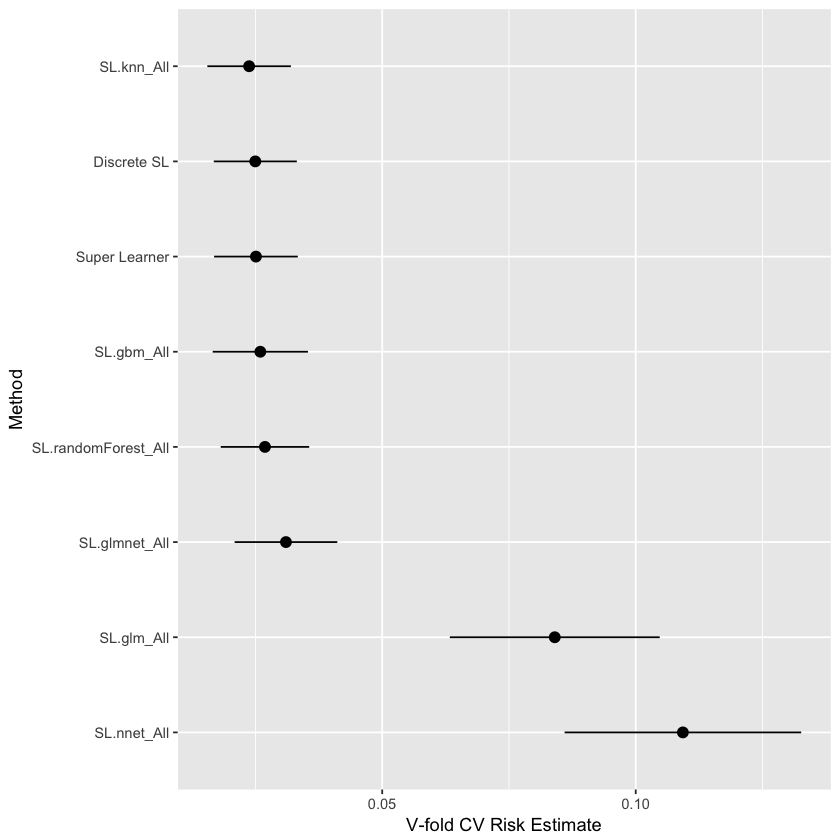

In [12]:
plot(cv_SL_fit)

In [14]:
fld = cv_SL_fit$fold
predsY = cv_SL_fit$SL.predict

n = length(predsY)
fold = rep(NA, n)

for(k in 1:V) {
    ii = unlist(fld[k])
    fold[ii] = k
}

ci_out = ci.cvAUC(predsY, Y, folds = fold)
txt = paste("AUC = ", round(ci_out$cvAUC, 2),", 95% CI = ", round(ci_out$ci[1], 2), "-", round(ci_out$ci[2], 2))

## Evaluating Classification Results

* The [Receiver Operating Characteristic curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is a standard way of evaluating the results of classification algorithms

* Here, we use the `ROCR` package to visualize the results from the cross-validated Super Learner

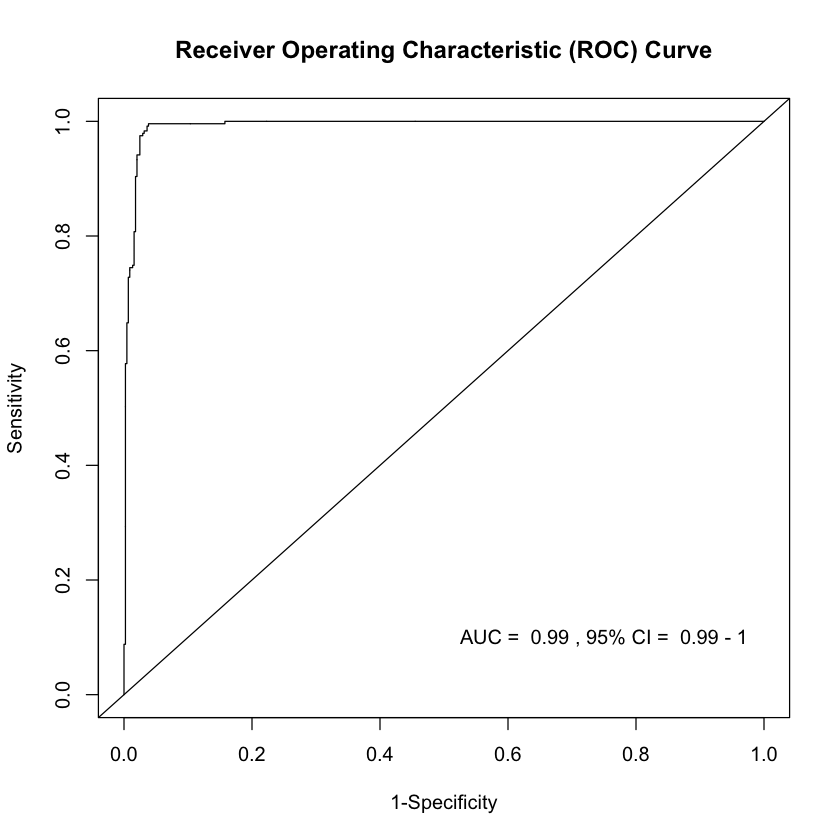

In [15]:
library(ROCR)

pred <- prediction(predsY, Y)
perf <- performance(pred, "sens", "spec")
plot(1 - slot(perf, "x.values")[[1]],
     slot(perf, "y.values")[[1]],
     type = "s",
     xlab = "1-Specificity",
     ylab = "Sensitivity",
     main = "Receiver Operating Characteristic (ROC) Curve")
text(0.75, 0.1, txt)
abline(0, 1)